# Difference-in-differences (DiD)

**Treatment period:**
\begin{equation}
Y_{it} = \beta_0 + \beta_1 D_i + \varepsilon_{it}
\end{equation}

$Y_{it}$ is the price for observation $i$ in time period $t$, 
$D_i$ is a dummy variable that takes the value of 1 during the treatment period and 0 otherwise, and 
$\beta_1$ captures the average treatment effect over time

**Treatment city:**
\begin{equation}
Y_{it} = \beta_0 + \beta_2 T_i + \varepsilon_{it}
\end{equation}

$T_i$ is a dummy variable that takes the value of 1 for the treatment city and 0 otherwise, 
$\beta_2$ captures the average difference in prices between the treatment city and the control cities

**Both (final equation):**
\begin{equation}
Y_{it} = \beta_0 + \beta_1 D_i + \beta_2 T_i + \alpha D_i T_i + \varepsilon_{it}
\end{equation}

$T_i$ is the treatment period dummy,
$D_i$ is the treatment city, 
$\alpha$ is the one that captures the DiD estimate, which is the differential change in prices for the treatment group compared to the control group, and
where $T_i = 1$ if individual $i$ is treatment period $t=1$ and $T_i=0$ otherwise


**Why use a second city**

The second city plays the role of a control group which is crucial for DiD analysis because it helps control for time-invariant unobserved factors that may affect prices in both the treatment and control groups. The key assumption in a DiD analysis is the parallel trends assumption, which implies that, in the absence of the treatment, the average outcomes for the treatment and control groups would follow parallel paths over time. Violation of this assumption could lead to biased estimates.


**Why $\alpha$ captures the treatment effect:**

If $\alpha$ is statistically significant and positive, it suggests that the treatment (event) had a differential impact on prices in the treatment city compared to the control cities. This coefficient captures the average treatment effect on prices that cannot be explained by time trends or differences between the treatment and control cities.



In [242]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.api as smf
import numpy as np

In [243]:
def openbarcelona(path):
    ''' Function to open 2 dataframes:
    - df1 which is the df of Barcelona the week of the event 
    - df2 which is the df of Barcelona another random no-event week
    '''
    df1 = pd.read_csv(path + '/barcelona_p1.csv')
    df2 = pd.read_csv(path + '/barcelona_p2.csv')
    return df1, df2

In [244]:
df1, df2 = openbarcelona('C:/Users/arimi/Documents/BSE-term2/text-mining/Booking-Scraping/data')

In [245]:
def choosecity(path, city):
    ''' Function to open 2 dataframes:
    - df1 which is the df of the choosen city the week of the event 
    - df2 which is the df of the choosen city another random no-event week
    '''
    df3 = pd.read_csv(path + city + '_p1.csv')
    df4 = pd.read_csv(path + city + '_p2.csv')
    return df3, df4

In [246]:
#Put the city all in low case
df3, df4 = choosecity('C:/Users/arimi/Documents/BSE-term2/text-mining/Booking-Scraping/data/', 'porto') 

In [247]:
# Eliminate the euro sign from the price feature and then transforming from object to numeric
df1['price'] = pd.to_numeric(df1['price'].replace('[^\d]', '', regex=True))
df2['price'] = pd.to_numeric(df2['price'].replace('[^\d]', '', regex=True))
df3['price'] = pd.to_numeric(df3['price'].replace('[^\d]', '', regex=True))
df4['price'] = pd.to_numeric(df4['price'].replace('[^\d]', '', regex=True))

In [248]:
df1.head()

,Unnamed: 0,place,start_date,end_date,name,price,description_short,rating,url,description
0,0,Barcelona,2024-02-23,2024-03-03,Duquesa Suites Barcelona,3491,NaN,8.8,https://www.booking.com/hotel/es/duquesa-suite...,"Set the centre of Barcelona, 400 metres from P..."
1,1,Barcelona,2024-02-23,2024-03-03,Sonder Casa Luz,4457,NaN,8.4,https://www.booking.com/hotel/es/casa-luz-barc...,"Set in Barcelona, Sonder Casa Luz offers a ter..."
2,2,Barcelona,2024-02-23,2024-03-03,Valencia 2,1395,NaN,NaN,https://www.booking.com/hotel/es/valencia-2.en...,"Located in Barcelona, 1.2 km from Passeig de G..."
3,3,Barcelona,2024-02-23,2024-03-03,Fuster Apartments by Aspasios,2448,Entire apartment • 2 bedrooms • 1 living room ...,9.2,https://www.booking.com/hotel/es/fuster-apartm...,Fuster Apartments are just 150 metres from Dia...
4,4,Barcelona,2024-02-23,2024-03-03,BarcelonaForRent The Central Place,5350,Entire apartment • 1 bedroom • 1 living room •...,8.5,https://www.booking.com/hotel/es/barcelonaforr...,"Offering views of Casa Batlló, BarcelonaForRen..."


In [249]:
df1.describe()

,Unnamed: 0,price,rating
count,1001.000000,1001.000000,945.000000
mean,500.000000,3379.912088,7.852804
std,289.108111,1836.851740,1.127298
min,0.000000,601.000000,1.000000
25%,250.000000,2317.000000,7.300000
50%,500.000000,2999.000000,8.000000
75%,750.000000,3903.000000,8.500000
max,1000.000000,17158.000000,10.000000


In [250]:
df1.shape

(1001, 10)

In [251]:
#Creation of the dummy variables for the regression
# D is treatment period
# T is treatment city
df1['D'] = 1
df1['T'] = 1
df2['D'] = 0
df2['T'] = 1
df3['D'] = 1
df3['T'] = 0
df4['D'] = 0
df4['T'] = 0

In [252]:
def remove_outliers(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

# Remove outliers from the 'price' column of your DataFrame
df3 = remove_outliers(df3, 'price')
df4 = remove_outliers(df4, 'price')
df1 = remove_outliers(df1, 'price')
df2 = remove_outliers(df2, 'price')

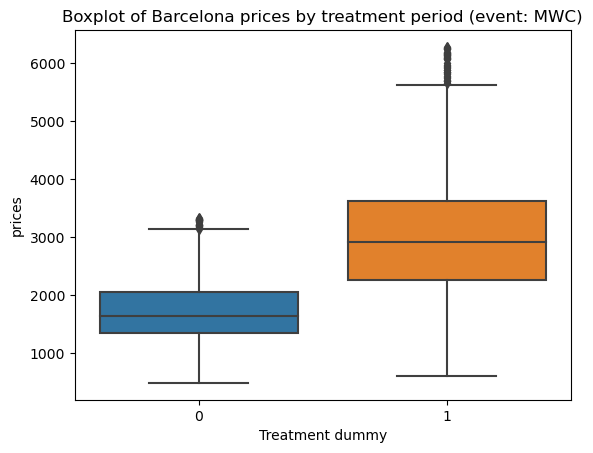

In [253]:
import seaborn as sns
import matplotlib.pyplot as plt

barcelona_df = pd.concat([df1, df2], ignore_index=True)

# Plotting boxplot using seaborn
sns.boxplot(data=barcelona_df , x='D', y='price')
plt.title('Boxplot of Barcelona prices by treatment period (event: MWC)')
plt.xlabel('Treatment dummy')
plt.ylabel('prices')
plt.show()

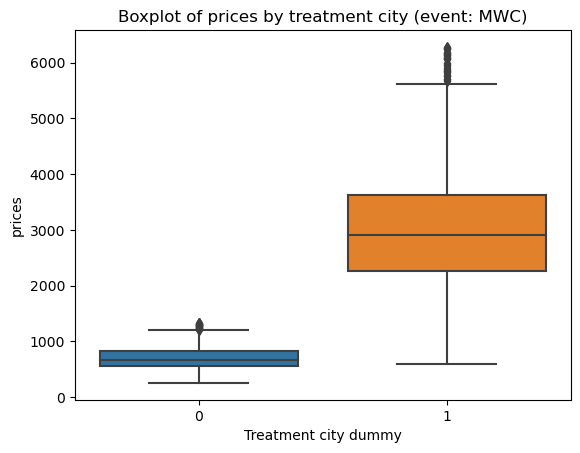

In [254]:
barcelona_city = pd.concat([df1, df3], ignore_index=True)
# Plotting boxplot using seaborn
sns.boxplot(data=barcelona_city , x='T', y='price')
plt.title('Boxplot of prices Barcelona by treatment city (event: MWC)')
plt.xlabel('Treatment city dummy')
plt.ylabel('prices')
plt.show()

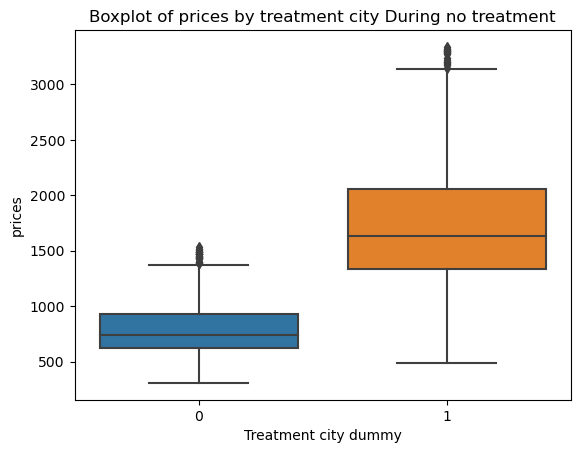

In [255]:
barcelona_cityNT = pd.concat([df2, df4], ignore_index=True)
# Plotting boxplot using seaborn
sns.boxplot(data=barcelona_cityNT , x='T', y='price')
plt.title('Boxplot of prices by treatment city During no treatment')
plt.xlabel('Treatment city dummy')
plt.ylabel('prices')
plt.show()

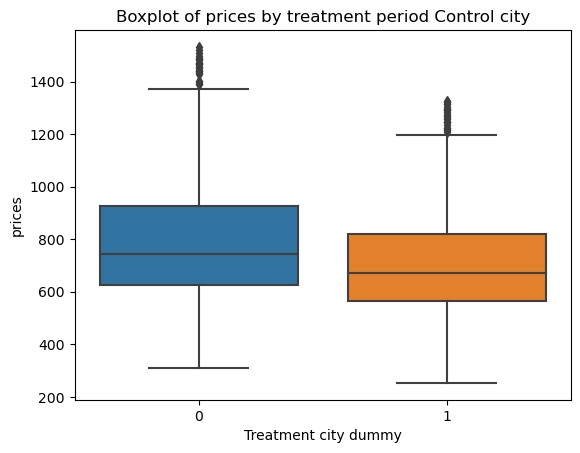

In [256]:
city = pd.concat([df3, df4], ignore_index=True)
# Plotting boxplot using seaborn
sns.boxplot(data=city , x='D', y='price')
plt.title('Boxplot of prices by treatment period Control city')
plt.xlabel('Treatment city dummy')
plt.ylabel('prices')
plt.show()

In [257]:
#Creation of the big data frame
combined_df = pd.concat([df1, df2, df3, df4], ignore_index=True)
combined_df['T*D'] = combined_df['T'] * combined_df['D']
# Display the combined DataFrame
combined_df.head()

,Unnamed: 0,place,start_date,end_date,name,price,description_short,rating,url,description,D,T,T*D
0,0,Barcelona,2024-02-23,2024-03-03,Duquesa Suites Barcelona,3491,NaN,8.8,https://www.booking.com/hotel/es/duquesa-suite...,"Set the centre of Barcelona, 400 metres from P...",1,1,1
1,1,Barcelona,2024-02-23,2024-03-03,Sonder Casa Luz,4457,NaN,8.4,https://www.booking.com/hotel/es/casa-luz-barc...,"Set in Barcelona, Sonder Casa Luz offers a ter...",1,1,1
2,2,Barcelona,2024-02-23,2024-03-03,Valencia 2,1395,NaN,NaN,https://www.booking.com/hotel/es/valencia-2.en...,"Located in Barcelona, 1.2 km from Passeig de G...",1,1,1
3,3,Barcelona,2024-02-23,2024-03-03,Fuster Apartments by Aspasios,2448,Entire apartment • 2 bedrooms • 1 living room ...,9.2,https://www.booking.com/hotel/es/fuster-apartm...,Fuster Apartments are just 150 metres from Dia...,1,1,1
4,4,Barcelona,2024-02-23,2024-03-03,BarcelonaForRent The Central Place,5350,Entire apartment • 1 bedroom • 1 living room •...,8.5,https://www.booking.com/hotel/es/barcelonaforr...,"Offering views of Casa Batlló, BarcelonaForRen...",1,1,1


In [258]:
combined_df.describe() #Checked if it worked 

,Unnamed: 0,price,rating,D,T,T*D
count,3744.000000,3744.000000,3526.000000,3744.000000,3744.000000,3744.000000
mean,494.111111,1570.938835,8.223426,0.502404,0.503205,0.250267
std,287.246828,1153.961479,1.008425,0.500061,0.500057,0.433225
min,0.000000,253.000000,1.000000,0.000000,0.000000,0.000000
25%,244.750000,696.000000,7.800000,0.000000,0.000000,0.000000
50%,494.000000,1134.000000,8.400000,1.000000,1.000000,0.000000
75%,743.250000,2153.000000,8.900000,1.000000,1.000000,1.000000
max,1000.000000,6282.000000,10.000000,1.000000,1.000000,1.000000


In [259]:
all = ['T', 'D', 'T*D'] 

# Function to estimate regression and return coefficients
def estimate_regression(df, column_name):
    model = sm.OLS(df['price'], sm.add_constant(df[column_name])).fit()
    coeff = model.params
    return coeff

# Regression 1: Treatment Period Dummy Only
regression_df1 = estimate_regression(combined_df, 'D')

# Regression 2: Treatment City Dummy Only
regression_df2 = estimate_regression(combined_df, 'T')

# Regression 3: Both Treatment Period and City Dummy with Interaction (DiD)
regression_df3 = estimate_regression(combined_df, all)

# Display the regression table
print(regression_df1)
print(regression_df2)
print(regression_df3)


const    1268.046162
D         602.886852
dtype: float64
const     752.578495
T        1626.295709
dtype: float64
const     794.289301
T         932.005313
D         -82.184428
T*D      1394.308170
dtype: float64


In [260]:
def estimate_regression(df, column_name):
    model = sm.OLS(df['price'], sm.add_constant(df[column_name])).fit()
    coeff = model.params
    return coeff

# Regression 1: Treatment Period Dummy Only
regression_df1 = estimate_regression(combined_df, 'D')

# Regression 2: Treatment City Dummy Only
regression_df2 = estimate_regression(combined_df, 'T')

# Regression 3: Both Treatment Period and City Dummy with Interaction (DiD)
regression_df3 = estimate_regression(combined_df, 'T*D')

# Display the regression table
print(regression_df1)
print(regression_df2)
print(regression_df3)

const    1268.046162
D         602.886852
dtype: float64
const     752.578495
T        1626.295709
dtype: float64
const    1081.081938
T*D      1957.336418
dtype: float64
